## Download the Data and Prepare the Library

In [0]:
# !pip install fastai==0.7.0
# import sys
# !{sys.executable} -m pip install torchtext==0.2.3
# !pip install torch==0.4

In [0]:
# !curl 'https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar' -o 'VOCtrainval_06-Nov-2007.tar' -H 'Connection: keep-alive' -H 'Pragma: no-cache' -H 'Cache-Control: no-cache' -H 'Upgrade-Insecure-Requests: 1' -H 'DNT: 1' -H 'User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3735.0 Safari/537.36' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'Accept-Encoding: gzip, deflate, br' -H 'Accept-Language: en-GB,en;q=0.9,en-US;q=0.8,bn;q=0.7' -H 'Cookie: __utmc=134107727; __utmz=134107727.1553054465.2.2.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utma=134107727.205412972.1553047529.1553054465.1553930584.3; __utmt=1; __utmb=134107727.1.10.1553930584' --compressed

# !curl 'https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar' -o 'VOCtest_06-Nov-2007.tar' -H 'Connection: keep-alive' -H 'Pragma: no-cache' -H 'Cache-Control: no-cache' -H 'Upgrade-Insecure-Requests: 1' -H 'DNT: 1' -H 'User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3735.0 Safari/537.36' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'Accept-Encoding: gzip, deflate, br' -H 'Accept-Language: en-GB,en;q=0.9,en-US;q=0.8,bn;q=0.7' -H 'Cookie: __utmc=134107727; __utmz=134107727.1553054465.2.2.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utma=134107727.205412972.1553047529.1553054465.1553930584.3; __utmt=1; __utmb=134107727.1.10.1553930584' --compressed

# !curl https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip -o PASCAL_VOC.zip

In [0]:
# !tar -xvf VOCtrainval_06-Nov-2007.tar

# !tar -xvf 'VOCtest_06-Nov-2007.tar'

# !unzip PASCAL_VOC.zip

In [0]:
# !mv VOCdevkit PASCAL_VOC

In [4]:
!ls PASCAL_VOC

pascal_test2007.json   pascal_train2012.json  pascal_val2012.json
pascal_train2007.json  pascal_val2007.json    VOCdevkit


## Loading the Libraries

In [0]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
from json import *
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [2]:
PATH = Path('PASCAL_VOC/')
list(PATH.iterdir())

[PosixPath('PASCAL_VOC/pascal_val2007.json'),
 PosixPath('PASCAL_VOC/pascal_train2012.json'),
 PosixPath('PASCAL_VOC/pascal_val2012.json'),
 PosixPath('PASCAL_VOC/VOCdevkit'),
 PosixPath('PASCAL_VOC/pascal_train2007.json'),
 PosixPath('PASCAL_VOC/pascal_test2007.json')]

In [3]:
trn_js = json.load((PATH/'pascal_train2007.json').open())
trn_js.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [0]:
IMAGES, ANNOTATIONS, CATEGORIES = 'images', 'annotations', 'categories'
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX, NAME = 'file_name', 'id', 'image_id', 'category_id', 'bbox', 'name'

cats = dict((o[ID], o[NAME]) for o in trn_js[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_js[IMAGES])
trn_idxs = [o[ID] for o in trn_js[IMAGES]]

In [0]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages/'
IMG_PATH = PATH/JPEGS

In [0]:
hw_bb = lambda bb: np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
bb_hw = lambda a: np.array([a[1], a[0], a[3]-a[1]+1, a[2]-a[0]+1])

In [0]:
def get_trn_anno():
  trn_anno = collections.defaultdict(lambda: [])
  for o in trn_js[ANNOTATIONS]:
    if not o['ignore']:
      bb = o[BBOX]
      bb = hw_bb(bb)
      trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
  return trn_anno

trn_anno = get_trn_anno()

In [0]:
def show_image(im, figsize=None, ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(12, 8))
  ax.imshow(im)
  ax.set_xticks(np.linspace(0, 224, 8))
  ax.set_yticks(np.linspace(0, 224, 8))
  ax.grid()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  return ax

def draw_outline(o, lw):
  o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'),
                      patheffects.Normal()])
  
def draw_rectangle(ax, bb, color='white'):
  patch = ax.add_patch(patches.Rectangle(bb[:2], *bb[-2:], fill=False, edgecolor=color, lw=2))
  draw_outline(patch, 4)
  
def draw_text(ax, xy, txt, sz=14, color='white'):
  text = ax.text(*xy, txt, verticalalignment='top', color=color, fontsize=sz,
                 weight='bold')
  draw_outline(text, 1)

In [0]:
def draw_image(im, anno):
  ax = show_image(im)
  for b, c in anno:
    b = bb_hw(b)
    draw_rectangle(ax, b)
    draw_text(ax, b[:2], cats[c], sz=16)

def draw_index(idx):
  im_a = trn_anno[idx]
  im = open_image(IMG_PATH/trn_fns[i])
  draw_image(im, im_a)

## Multi Class

In [0]:
MC_CSV = PATH/'tmp/mc.csv'

In [0]:
mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_idxs]
mcs = [' '.join(str(p) for p in o) for o in mc]

In [0]:
(PATH/'tmp/').mkdir(exist_ok=True)

In [0]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_idxs], 'clas': mcs},
                  columns=['fn', 'clas'])
df.to_csv(MC_CSV, index=False)

In [36]:
df.head()

,fn,clas
0,000012.jpg,car
1,000017.jpg,horse person
2,000023.jpg,person bicycle
3,000026.jpg,car
4,000032.jpg,aeroplane person


In [0]:
f_model = resnet34
sz=224
bs=64

In [0]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms, bs=bs)

In [40]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 48123932.69it/s]
/usr/local/lib/python3.6/dist-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [41]:
learn.lr_find(1e-5, 100)

epoch      trn_loss   val_loss   <lambda>   
    0      2.024958   8.164968   0.7045    



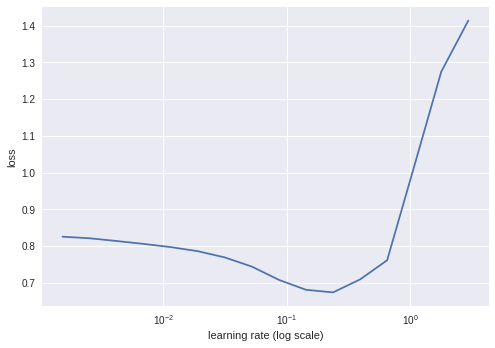

In [42]:
learn.sched.plot()

In [43]:
lr = 2e-2
learn.fit(lr, 1, cycle_len=3, use_clr=(32, 5))

epoch      trn_loss   val_loss   <lambda>   
    0      0.326123   0.136618   0.9551    
    1      0.174525   0.079144   0.9733    
    2      0.116886   0.075391   0.9743    



[0.07539074271917343, 0.9743000035285949]

In [0]:
lrs = np.array([lr/100, lr/10, lr])
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:21<00:02,  1.69it/s, loss=0.423]

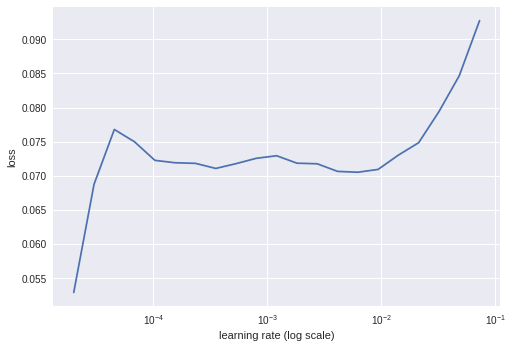

In [45]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [46]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32, 5))

epoch      trn_loss   val_loss   <lambda>   
    0      0.071435   0.076311   0.9726    
    1      0.053274   0.079841   0.9749    
    2      0.03878    0.078914   0.9755    
    3      0.027144   0.076269   0.9762    
    4      0.019341   0.078001   0.9764    


[0.07800072437524795, 0.976400002002716]

In [0]:
learn.save('multiclas')
learn.load('multiclas')

In [0]:
y = learn.predict()
x, _ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


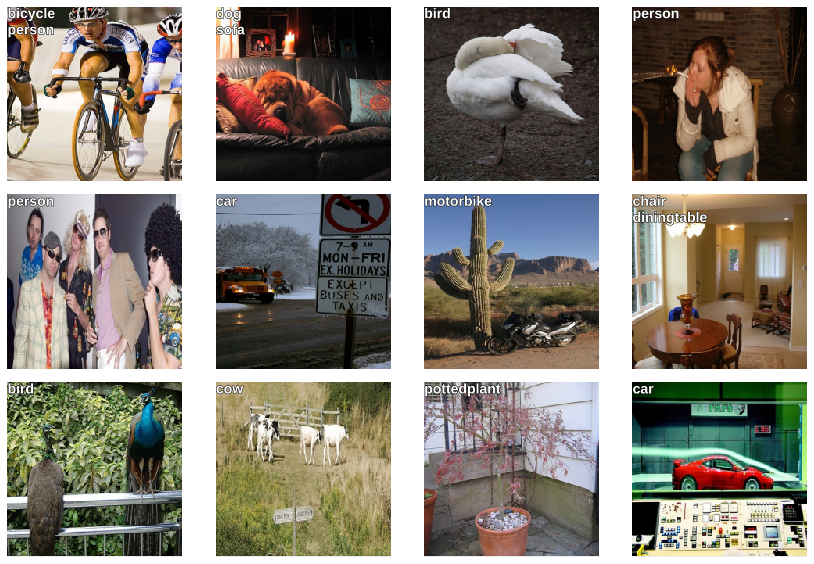

In [56]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
  ima = md.val_ds.denorm(x)[i]
  ya = np.nonzero(y[i] > 0.4)[0]
  b = '\n'.join(md.classes[o] for o in ya)
  ax = show_image(ima, ax=ax)
  draw_text(ax, (0, 0), b)
plt.tight_layout()

## BBOX

### Setup Data

In [0]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

In [0]:
f_model = resnet34
sz=224
bs=64

In [62]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_idxs]
id2cat = list(cats.values())
cat2id = {v:k for k, v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [0]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs),) = split_by_idx(val_idxs, mcs)

In [0]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_idxs]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

In [0]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_idxs], 'bbox': mbbs},
                  columns=['fn', 'bbox'])
df.to_csv(MBB_CSV, index=False)

In [67]:
df.head()

,fn,bbox
0,000012.jpg,96 155 269 350
1,000017.jpg,61 184 198 278 77 89 335 402
2,000023.jpg,229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3,000026.jpg,124 89 211 336
4,000032.jpg,77 103 182 374 87 132 122 196 179 194 228 212 ...


In [0]:
aug_tfms = [RandomFlip(tfm_y=TfmType.COORD),
            RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, bs=bs,
                                  continuous=True, num_workers=4)

In [0]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
  color_norm = mcolors.Normalize(vmin=0, vmax=N-1)
  return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba


num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

In [0]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
  bb = [bb_hw(o) for o in bbox.reshape(-1, 4)]
  if prs is None: prs = [None] * len(bb)
  if clas is None: clas = [None] * len(bb)
  ax = show_image(im, ax=ax)
  for i, (b, c, pr) in enumerate(zip(bb, clas, prs)):
    if ((b[2]>0) and (pr is None or pr > thresh)):
      draw_rectangle(ax, b, color=color_list[i%num_color])
      txt = f'{i}: '
      if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
      if pr is not None: txt += f' {pr:.2f}'
      draw_text(ax, b[:2], txt, color=color_list[i%num_color])

In [0]:
class ConcatLblDataset(Dataset):
  def __init__(self, ds, y2):
    self.ds, self.y2 = ds, y2
    self.sz = ds.sz
    
  def __len__(self):
    return len(self.sz)
  
  def __getitem__(self, i):
    x, y = self.ds[i]
    return (x, (y, self.y2[i]))

In [0]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [0]:
x, y = to_np(next(iter(md.val_dl)))
x = md.val_ds.ds.denorm(x)

In [0]:
x, y = to_np(next(iter(md.trn_dl)))
x = md.trn_ds.ds.denorm(x)

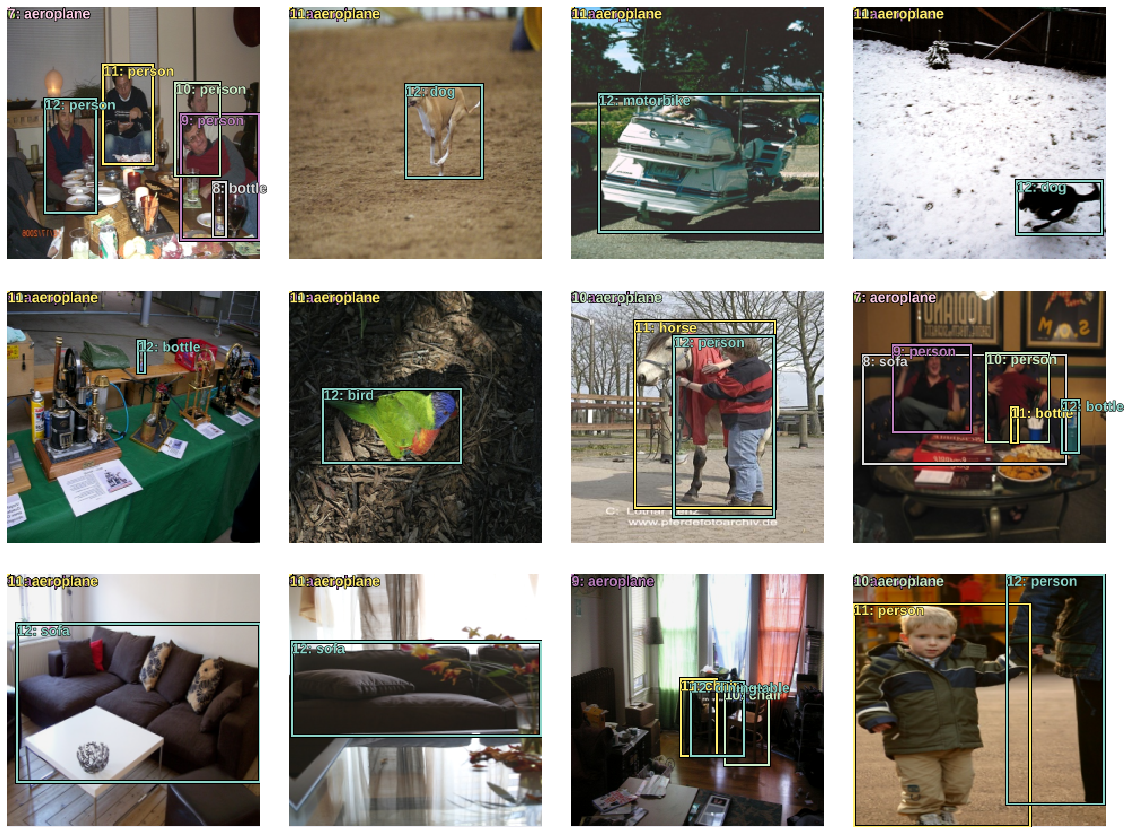

In [112]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i, ax in enumerate(axes.flat):
  show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

### Setup The Model

In [0]:
anc_grid = 4
k = 1
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis=1), (k, 1))
anc_sizes = np.array([[1/anc_grid, 1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False)

In [0]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

(0, 1)

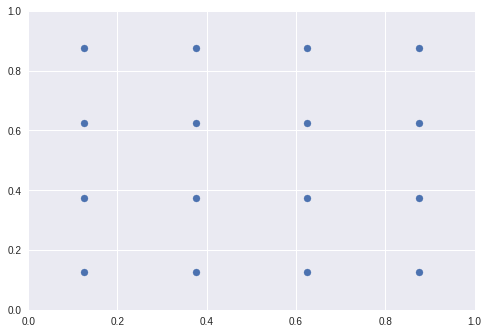

In [117]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [118]:
anchors

tensor([[ 0.1250,  0.1250,  0.2500,  0.2500],
        [ 0.1250,  0.3750,  0.2500,  0.2500],
        [ 0.1250,  0.6250,  0.2500,  0.2500],
        [ 0.1250,  0.8750,  0.2500,  0.2500],
        [ 0.3750,  0.1250,  0.2500,  0.2500],
        [ 0.3750,  0.3750,  0.2500,  0.2500],
        [ 0.3750,  0.6250,  0.2500,  0.2500],
        [ 0.3750,  0.8750,  0.2500,  0.2500],
        [ 0.6250,  0.1250,  0.2500,  0.2500],
        [ 0.6250,  0.3750,  0.2500,  0.2500],
        [ 0.6250,  0.6250,  0.2500,  0.2500],
        [ 0.6250,  0.8750,  0.2500,  0.2500],
        [ 0.8750,  0.1250,  0.2500,  0.2500],
        [ 0.8750,  0.3750,  0.2500,  0.2500],
        [ 0.8750,  0.6250,  0.2500,  0.2500],
        [ 0.8750,  0.8750,  0.2500,  0.2500]], device='cuda:0')

In [0]:
def hw2corners(ctr, hw):
  return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [120]:
anchor_cnr = hw2corners(anchors[:, :2], anchors[:, 2:]); anchor_cnr

tensor([[ 0.0000,  0.0000,  0.2500,  0.2500],
        [ 0.0000,  0.2500,  0.2500,  0.5000],
        [ 0.0000,  0.5000,  0.2500,  0.7500],
        [ 0.0000,  0.7500,  0.2500,  1.0000],
        [ 0.2500,  0.0000,  0.5000,  0.2500],
        [ 0.2500,  0.2500,  0.5000,  0.5000],
        [ 0.2500,  0.5000,  0.5000,  0.7500],
        [ 0.2500,  0.7500,  0.5000,  1.0000],
        [ 0.5000,  0.0000,  0.7500,  0.2500],
        [ 0.5000,  0.2500,  0.7500,  0.5000],
        [ 0.5000,  0.5000,  0.7500,  0.7500],
        [ 0.5000,  0.7500,  0.7500,  1.0000],
        [ 0.7500,  0.0000,  1.0000,  0.2500],
        [ 0.7500,  0.2500,  1.0000,  0.5000],
        [ 0.7500,  0.5000,  1.0000,  0.7500],
        [ 0.7500,  0.7500,  1.0000,  1.0000]], device='cuda:0')

In [0]:
n_clas = len(id2cat) + 1
n_act = k * (4 + n_clas)

In [0]:
class StdConv(nn.Module):
  def __init__(self, nin, nout, stride=2, drop=0.1):
    super().__init__()
    self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
    self.bn = nn.BatchNorm2d(nout)
    self.drop = nn.Dropout(drop)
    
  def forward(self, x):
    return self.drop(self.bn(F.relu(self.conv(x))))

In [0]:
def flatten_conv(x, k):
  bs, nf, gx, gy = x.size()
  x = x.permute(0, 2, 3, 1).contiguous()
  return x.view(bs, -1, nf//k)

In [0]:
class OutConv(nn.Module):
  def __init__(self, k, nin, bias):
    super().__init__()
    self.k = k
    self.oconv1 = nn.Conv2d(nin, (len(id2cat) +1) * k, 3, padding=1)
    self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
    self.oconv1.bias.data.zero_().add(bias)
    
  def foward(self, x):
    return [flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)]

In [0]:
class SSD_Head(nn.Module):
  def __init__(self, k, bias):
    super().__init__()
    self.drop = nn.Dropout(0.25)
    self.sconv0 = StdConv(512, 256, stride=1)
    self.sconv1 = StdConv(256, 256)
    self.out = OutConv(k, 256, bias)
    
  def forward(self, x):
    x = self.drop(F.relu(x))
    x = self.sconv0(x)
    x = self.sconv1(x)
    return self.out(x)

In [126]:
head_reg4 = SSD_Head(k, -3)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1